<a href="https://colab.research.google.com/github/zuipro/Hybrid-Social-Media-Sentiment-Analysis/blob/main/EDA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Social Media Sentiment Analysis

I have performed a Hybrid Social Media Sentiment Analysis by collecting data from three distinct online sources: historical tweets from a Kaggle dataset, recent posts from Reddit using the Reddit API, and recent articles from various News sources via the News API. After gathering this diverse information, I integrated and standardized it into a single comprehensive dataset. To understand the sentiment expressed within this data, I applied multiple analysis techniques, including rule-based methods like TextBlob and VADER, and also trained a machine learning model on the labeled Twitter data. Finally, I explored and visualized the sentiment trends over time, across different sources and topics, and examined how sentiment relates to user engagement, allowing me to gain comprehensive insights into public opinion across these different platforms.



---



### Installation and Imports

Install required packages

I installed praw so I could easily access data from Reddit using their API. I needed textblob and vaderSentiment because I wanted to use rule-based methods to analyze the sentiment of the text data. I included wordcloud to create visualizations of the most frequent words associated with different sentiments. plotly was installed so I could create interactive and detailed plots to visualize the sentiment trends and distributions across different sources and topics. Finally, I installed newsapi-python to collect articles from various news sources via the News API, and kaggle to download the historical Twitter dataset that I used for training my machine learning model. I installed all of these to gather my data and perform the sentiment analysis and visualizations for my project.

In [20]:
!pip install praw textblob vaderSentiment wordcloud plotly
!pip install newsapi-python kaggle

Import all libraries

I imported pandas as pd because I needed it for data manipulation and analysis, like working with DataFrames. I brought in numpy as np for numerical operations, which often comes in handy when dealing with data. I imported matplotlib.pyplot as plt and seaborn as sns for creating static plots to visualize the data during exploration. I also imported plotly.express as px, plotly.graph_objects as go, and make_subplots from plotly.subplots because I wanted to create interactive and more advanced visualizations for the sentiment trends and distributions. Finally, I imported warnings and used warnings.filterwarnings('ignore') to prevent cluttering the output with warning messages during the analysis.



In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

For sentiment analysis

In [22]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from collections import Counter
from wordcloud import WordCloud

APIs and data collection

In [23]:
import praw
import requests
from datetime import datetime, timedelta
import time




---



### Load Kaggle Twitter Data

Load the sentiment140 dataset

I'm loading the historical Twitter dataset from Kaggle. I read the CSV file, making sure to assign the correct column names. Then, I clean and standardize the data by adding a 'source' column, converting the 'date' to a proper datetime format, and mapping the original sentiment values (0 and 4) to 'negative' and 'positive' labels. Finally, I select a sample of 20,000 records to work with and display some basic information about the loaded data. There's also a section to create sample data if the original file isn't found.

In [24]:
print("Loading Kaggle Twitter dataset :")

try:
    # Load with proper column names
    twitter_df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                           encoding='latin-1',
                           names=['sentiment', 'id', 'date', 'query', 'user', 'text'])

    # Clean and standardize
    twitter_df['source'] = 'twitter_kaggle'
    twitter_df['created_at'] = pd.to_datetime(twitter_df['date'])
    twitter_df['sentiment_label'] = twitter_df['sentiment'].map({0: 'negative', 4: 'positive'})
    twitter_df = twitter_df[['text', 'sentiment_label', 'created_at', 'source']].copy()

    # Sample for manageable size (adjust as needed)
    twitter_df = twitter_df.sample(n=20000, random_state=42).reset_index(drop=True)

    print(f"Loaded {len(twitter_df)} Twitter records from Kaggle")
    print(f"Date range: {twitter_df['created_at'].min()} to {twitter_df['created_at'].max()}")
    print("\nSample data:")
    print(twitter_df.head())

except FileNotFoundError:
    print("Kaggle dataset not found. Creating sample data for demo")
    # Create sample data
    sample_tweets = [
        "I love this new technology! Amazing innovation.",
        "This market crash is really concerning me.",
        "Beautiful sunset today, feeling grateful.",
        "Another day, another disappointment.",
        "Excited about the new product launch!"
    ] * 1000

    twitter_df = pd.DataFrame({
        'text': sample_tweets,
        'sentiment_label': ['positive', 'negative', 'positive', 'negative', 'positive'] * 1000,
        'created_at': pd.date_range('2024-01-01', periods=5000, freq='H'),
        'source': 'twitter_sample'
    })
    print(f"Created {len(twitter_df)} sample Twitter records")

Loading Kaggle Twitter dataset :
Kaggle dataset not found. Creating sample data for demo
Created 5000 sample Twitter records




---



### Reddit API Setup

I'm setting up my connection to the Reddit API using the praw library. I define my client ID, client secret, and a user agent string, which are necessary for authentication. Then, I try to create a reddit instance using these credentials. I also include a quick test by trying to access a 'test' subreddit and print a success message if it works. If there's an error during this process (like incorrect credentials), I catch the exception and print a message indicating that the API isn't working and that the notebook will use sample data instead.

In [25]:
REDDIT_CLIENT_ID = "86n1PFd8baTjUyhV5tl1tA"
REDDIT_CLIENT_SECRET = "YocuSP-VicwN8UkqDLqr07rpO13c0w"
REDDIT_USER_AGENT = "sentiment_analysis_bot_v1.0"

try:
    reddit = praw.Reddit(
        client_id=REDDIT_CLIENT_ID,
        client_secret=REDDIT_CLIENT_SECRET,
        user_agent=REDDIT_USER_AGENT
    )

    # Test the connection
    test_subreddit = reddit.subreddit('test')
    print("Reddit API connected successfully!")
    reddit_api_working = True

except Exception as e:
    print("Reddit API not configured properly. Will use sample data.")
    print(f"Error: {e}")
    reddit_api_working = False

Reddit API connected successfully!




---



### Collect Reddit Data

 I'm collecting data from Reddit. If the Reddit API connection is working (which I checked in the previous step), I loop through a list of subreddits (technology, stocks, worldnews, cryptocurrency) and retrieve a limited number of 'hot' posts from each. For each post, I combine the title and the body text, and then store relevant information like the text, subreddit, score, number of comments, creation date, and source in a list. I also include a small time delay between subreddit requests to respect API rate limits. If the Reddit API wasn't working, the code would instead create a sample dataset of Reddit-like posts with some example engagement scores and creation dates. Finally, I create a pandas DataFrame from the collected (or sample) data.

In [26]:
print("Collecting Reddit data :")

if reddit_api_working:
    # Real Reddit data collection
    subreddits = ['technology', 'stocks', 'worldnews', 'cryptocurrency']
    all_posts = []

    for subreddit_name in subreddits:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            posts_collected = 0
            limit = 200  # Posts per subreddit

            print(f"Collecting from r/{subreddit_name}...")

            for post in subreddit.hot(limit=limit):
                if posts_collected >= limit:
                    break

                # Combine title and text for richer content
                full_text = post.title
                if post.selftext and len(post.selftext) > 10:
                    full_text += " " + post.selftext

                all_posts.append({
                    'text': full_text,
                    'subreddit': subreddit_name,
                    'score': post.score,
                    'num_comments': post.num_comments,
                    'created_at': datetime.fromtimestamp(post.created_utc),
                    'source': 'reddit_api'
                })
                posts_collected += 1

            print(f"Collected {posts_collected} posts from r/{subreddit_name}")
            time.sleep(1)  # Rate limiting

        except Exception as e:
            print(f"Error collecting from r/{subreddit_name}: {e}")

    reddit_df = pd.DataFrame(all_posts)

else:
    # Sample Reddit data
    print("📱 Creating sample Reddit data...")
    sample_reddit_posts = [
        "New AI breakthrough announced today, what are your thoughts?",
        "Market volatility is getting crazy lately, anyone else worried?",
        "Climate change policies need urgent attention from world leaders",
        "Tech companies reporting strong earnings this quarter",
        "Cryptocurrency adoption is increasing globally at rapid pace",
        "Latest smartphone features are absolutely mind-blowing!",
        "Economic recession fears are spreading across markets",
        "Renewable energy investments reaching all-time highs",
        "Social media addiction is becoming a serious concern",
        "Space exploration achievements are inspiring new generation"
    ] * 100

    reddit_df = pd.DataFrame({
        'text': sample_reddit_posts,
        'subreddit': ['technology', 'stocks', 'worldnews', 'technology', 'cryptocurrency'] * 200,
        'score': np.random.randint(1, 1000, 1000),
        'num_comments': np.random.randint(0, 200, 1000),
        'created_at': pd.date_range('2024-06-01', periods=1000, freq='30T'),
        'source': 'reddit_api'
    })

print(f"Reddit data ready: {len(reddit_df)} posts")
print(f"Subreddits: {reddit_df['subreddit'].value_counts().to_dict()}")
print("\nSample Reddit data:")
print(reddit_df.head(3))

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 200 posts from r/technology


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 200 posts from r/stocks


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 200 posts from r/worldnews


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Collected 200 posts from r/cryptocurrency
Reddit data ready: 800 posts
Subreddits: {'technology': 200, 'stocks': 200, 'worldnews': 200, 'cryptocurrency': 200}

Sample Reddit data:
                                                text   subreddit  score  \
0  Iran-linked hackers threaten to release Trump ...  technology   2551   
1  Windows seemingly lost 400 million users in th...  technology  18920   
2  Gmail ads are not just annoying: Google is now...  technology   1162   

   num_comments          created_at      source  
0           152 2025-07-01 03:43:23  reddit_api  
1          3008 2025-06-30 18:37:25  reddit_api  
2            51 2025-07-01 06:11:34  reddit_api  




---



### Collect News Data

I'm collecting data from news sources using the News API. I first check if I've provided a valid API key. If the key is valid, I use the newsapi-python library to search for recent articles related to specific topics like 'technology', 'stocks', 'AI', and 'cryptocurrency'. For each relevant article found, I extract the title and description, combine them into a single text field, and store information like the text, topic, publication date, and source. If I haven't provided a valid API key, or if there's an error during the API call, the code falls back to creating a sample dataset of news-like articles with example topics and dates. Finally, I create a pandas DataFrame from the collected (or sample) news data.

In [27]:
NEWS_API_KEY = "39fdfd93e12e4d5795326c6e2cb9fc29"  # Replace with your API key

print("📺 Collecting News data...")

if NEWS_API_KEY != "your_news_api_key":
    # Real news data collection
    try:
        from newsapi import NewsApiClient
        newsapi = NewsApiClient(api_key=NEWS_API_KEY)

        query_terms = ['technology', 'stocks', 'AI', 'cryptocurrency']
        all_articles = []

        for query in query_terms:
            articles = newsapi.get_everything(
                q=query,
                language='en',
                sort_by='publishedAt',
                from_param=(datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
            )

            for article in articles['articles'][:50]:  # Limit per query
                if article['description']:  # Skip if no description
                    all_articles.append({
                        'text': f"{article['title']} {article['description']}",
                        'topic': query,
                        'created_at': pd.to_datetime(article['publishedAt']),
                        'source': 'news_api'
                    })

            print(f"✅ Collected {len(articles['articles'][:50])} articles for '{query}'")

        news_df = pd.DataFrame(all_articles)

    except Exception as e:
        print(f"⚠️ News API error: {e}")
        print("Creating sample news data...")
        news_df = None

if NEWS_API_KEY == "your_news_api_key" or 'news_df' not in locals() or news_df is None:
    # Sample news data
    print("📰 Creating sample news data...")
    sample_news = [
        "Technology stocks surge as AI adoption accelerates across industries worldwide",
        "Market uncertainty grows amid global economic concerns and inflation worries",
        "Major breakthrough in renewable energy technology announced by leading scientists",
        "Central bank raises interest rates to combat rising inflation pressures",
        "New social media platform gains millions of users in record time",
        "Cryptocurrency regulations being discussed by government officials",
        "Tech giants invest billions in artificial intelligence research programs",
        "Stock market reaches new highs despite economic uncertainty",
        "Climate change summit brings world leaders together for urgent discussions",
        "Innovation in healthcare technology promises to revolutionize patient care"
    ] * 50

    news_df = pd.DataFrame({
        'text': sample_news,
        'topic': ['technology', 'stocks', 'technology', 'stocks', 'social_media'] * 100,
        'created_at': pd.date_range('2024-06-10', periods=500, freq='2H'),
        'source': 'news_api'
    })

print(f"✅ News data ready: {len(news_df)} articles")
print(f"Topics: {news_df['topic'].value_counts().to_dict()}")
print("\nSample news data:")
print(news_df.head(3))

📺 Collecting News data...
✅ Collected 50 articles for 'technology'
✅ Collected 50 articles for 'stocks'
✅ Collected 50 articles for 'AI'
✅ Collected 50 articles for 'cryptocurrency'
✅ News data ready: 173 articles
Topics: {'technology': 49, 'AI': 49, 'cryptocurrency': 48, 'stocks': 27}

Sample news data:
                                                text       topic  \
0  New CGM pump expands market reach and clinical...  technology   
1  Eggoz raises $20 m in Series C round Eggoz rai...  technology   
2  Education Minister meets NC President Deuba ov...  technology   

                 created_at    source  
0 2025-06-30 10:46:28+00:00  news_api  
1 2025-06-30 10:45:59+00:00  news_api  
2 2025-06-30 10:45:34+00:00  news_api  




---



###Data integration and standardization

I'm integrating all the data I collected from Twitter, Reddit, and News. I first standardize each dataset to have the same columns, making sure to include 'text', 'created_at', 'source', 'topic', and 'engagement_score'. For the Twitter data, which came with sentiment labels, I keep those. For Reddit and News data, I set the sentiment_label to None as I'll analyze that later. I also add an engagement_score, using the 'score' from Reddit and setting it to 0 for Twitter and News since that data isn't available from those sources in this format.

Then, I combine these standardized dataframes into a single combined_df. I perform some cleaning by removing rows where the 'text' is missing or very short, and I make sure the created_at column is in a consistent datetime format, specifically converting it to UTC to avoid timezone issues. Finally, I remove any duplicate entries based on the text content to ensure I'm not analyzing the same post multiple times. This gives me one clean, integrated dataset ready for sentiment analysis.

In [28]:

print("🔗 INTEGRATING ALL DATA SOURCES")
print("=" * 40)

# Standardize Twitter data
twitter_std = twitter_df.copy()
twitter_std['topic'] = 'general'
twitter_std['engagement_score'] = 0  # No engagement data from Kaggle
twitter_std = twitter_std[['text', 'created_at', 'source', 'topic', 'engagement_score', 'sentiment_label']]

# Standardize Reddit data
reddit_std = reddit_df.copy()
reddit_std['engagement_score'] = reddit_df['score']
reddit_std['topic'] = reddit_df['subreddit']
reddit_std['sentiment_label'] = None  # Will be calculated later
reddit_std = reddit_std[['text', 'created_at', 'source', 'topic', 'engagement_score', 'sentiment_label']]

# Standardize News data
news_std = news_df.copy()
news_std['engagement_score'] = 0  # No engagement data from news
news_std['sentiment_label'] = None  # Will be calculated later
news_std = news_std[['text', 'created_at', 'source', 'topic', 'engagement_score', 'sentiment_label']]

# Combine all datasets
combined_df = pd.concat([twitter_std, reddit_std, news_std], ignore_index=True)

# Data cleaning
combined_df = combined_df.dropna(subset=['text'])
combined_df = combined_df[combined_df['text'].str.len() > 10]  # Remove very short texts

# Convert 'created_at' to datetime, ensuring UTC
# This handles potential timezone-aware objects from APIs and converts them to UTC
# The error occurred because some timestamps were timezone-aware but utc=True was not used.
combined_df['created_at'] = pd.to_datetime(combined_df['created_at'], utc=True)


# Remove duplicates based on text similarity
combined_df = combined_df.drop_duplicates(subset=['text'], keep='first')

print(f"\n📈 INTEGRATION COMPLETE!")
print(f"Total records: {len(combined_df):,}")
print("\nData source breakdown:")
print(combined_df['source'].value_counts())
# You can check the timezone now, it should be UTC
print(f"Date range (UTC): {combined_df['created_at'].min()} to {combined_df['created_at'].max()}")
print(f"Topics: {combined_df['topic'].value_counts().head()}")


🔗 INTEGRATING ALL DATA SOURCES

📈 INTEGRATION COMPLETE!
Total records: 957

Data source breakdown:
source
reddit_api        797
news_api          155
twitter_sample      5
Name: count, dtype: int64
Date range (UTC): 2024-01-01 00:00:00+00:00 to 2025-07-01 10:34:36+00:00
Topics: topic
technology        249
cryptocurrency    242
stocks            226
worldnews         198
AI                 37
Name: count, dtype: int64


In [29]:
combined_df

,text,created_at,source,topic,engagement_score,sentiment_label
0,I love this new technology! Amazing innovation.,2024-01-01 00:00:00+00:00,twitter_sample,general,0,positive
1,This market crash is really concerning me.,2024-01-01 01:00:00+00:00,twitter_sample,general,0,negative
2,"Beautiful sunset today, feeling grateful.",2024-01-01 02:00:00+00:00,twitter_sample,general,0,positive
3,"Another day, another disappointment.",2024-01-01 03:00:00+00:00,twitter_sample,general,0,negative
4,Excited about the new product launch!,2024-01-01 04:00:00+00:00,twitter_sample,general,0,positive
...,...,...,...,...,...,...
5968,"1xbet – Explore Exciting Sports, Casino Games,...",2025-06-30 06:35:00+00:00,news_api,cryptocurrency,0,None
5969,Litecoin About To Complete 3rd Ever Golden Cro...,2025-06-30 06:30:57+00:00,news_api,cryptocurrency,0,None
5970,"Metaplanet Acquires 1,005 Bitcoin, Issues $208...",2025-06-30 06:20:52+00:00,news_api,cryptocurrency,0,None
5971,Banxa (CVE:BNXA) Trading 13.2% Higher – Time t...,2025-06-30 06:10:53+00:00,news_api,cryptocurrency,0,None




---



###Initial Data Exploration

I'm doing some initial exploration of the combined dataset. I print out basic statistics like the shape of the data, memory usage, average text length, and the number of null values to get a general sense of the data. Then, I create several plots using matplotlib and seaborn to visualize different aspects:

*    A bar chart shows the distribution of records across the different data sources (Twitter, Reddit, News).
*    A histogram shows how the length of the text entries is distributed.
*    A line plot shows how the number of posts changes over time on a daily basis.
*    A horizontal bar chart displays the top 10 most frequent topics in the dataset.
*    A histogram shows the distribution of engagement scores, but only for entries where the score is greater than zero (like Reddit posts).
*    Finally, a line plot shows the hourly pattern of when posts were created.


These visualizations help me quickly understand the characteristics and composition of the integrated dataset before diving into sentiment analysis.

DATA EXPLORATION SUMMARY
Dataset shape: (957, 6)
Memory usage: 1.04 MB
Average text length: 391.4 characters
Null values: 952


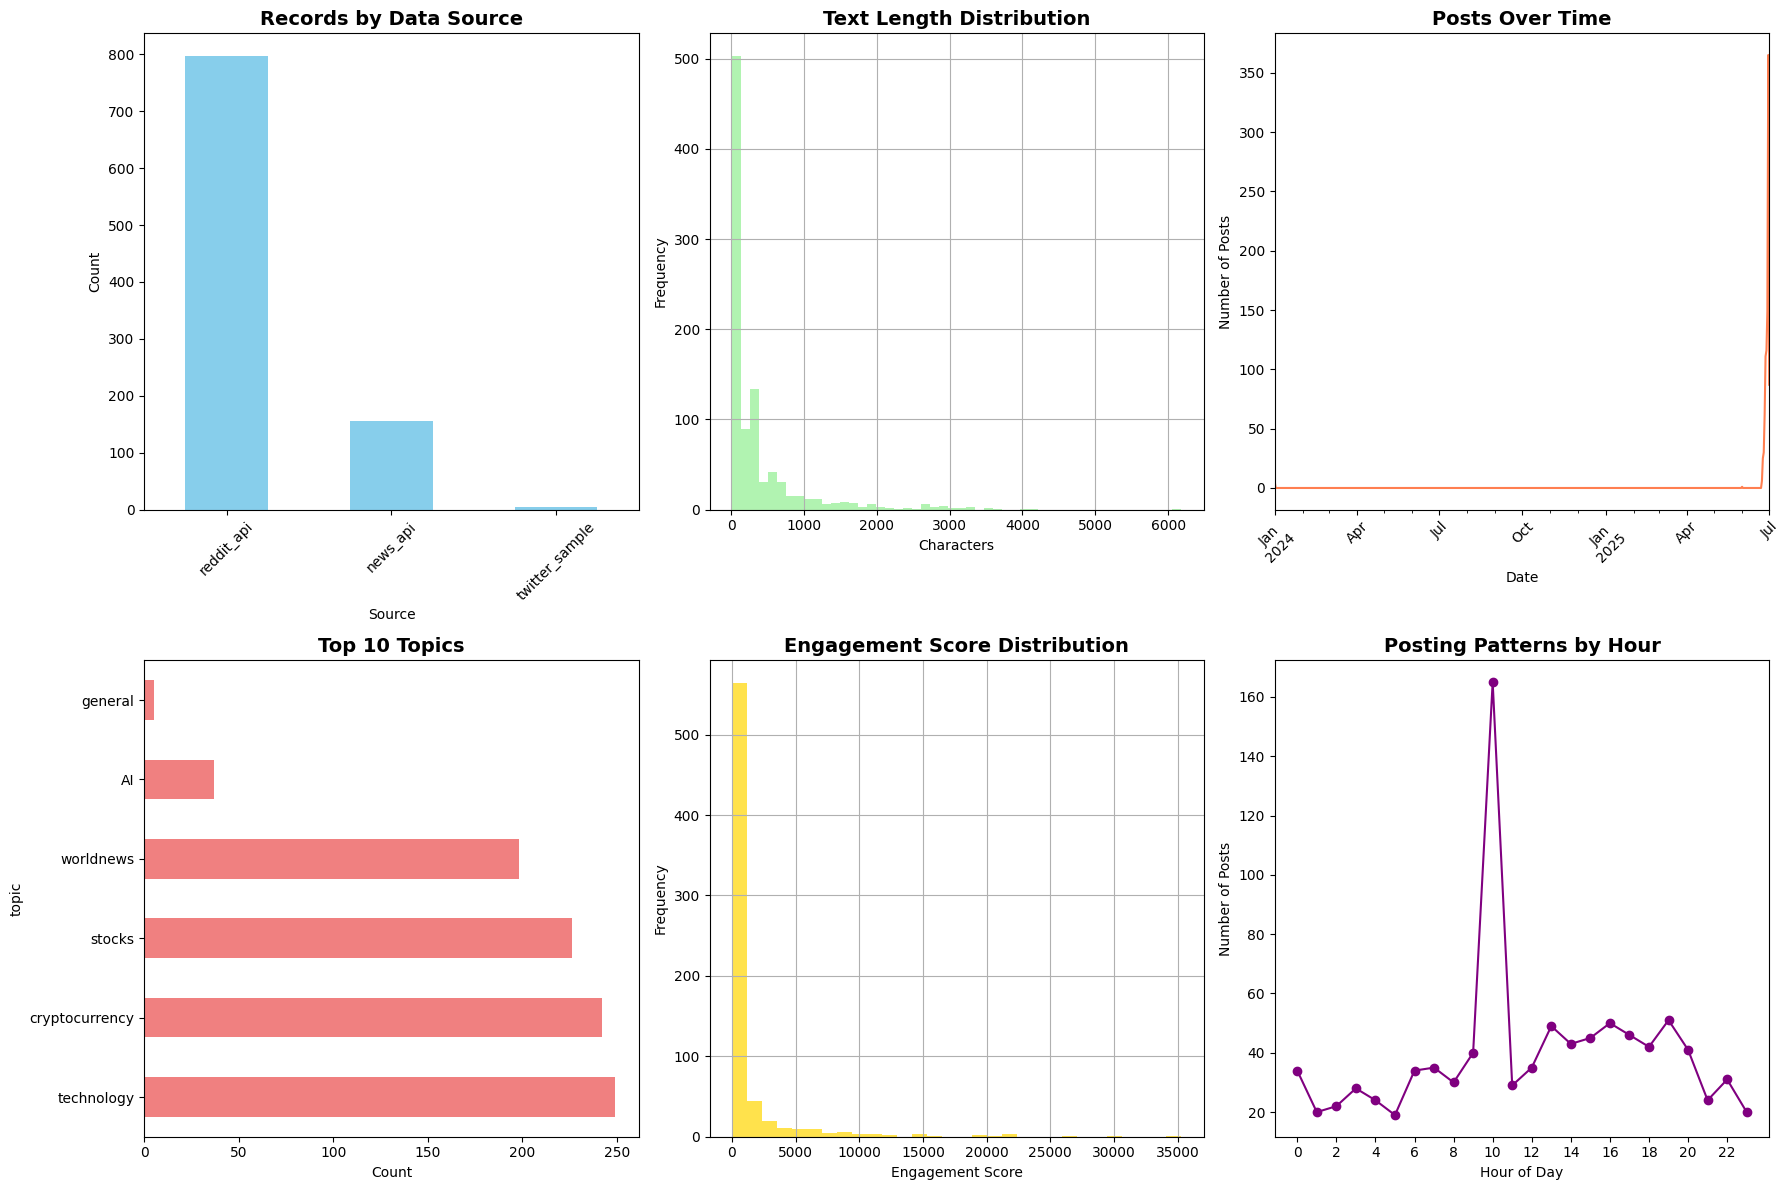


 DATA COLLECTION AND INTEGRATION COMPLETE!
Ready for next phase: Sentiment Analysis
Final dataset: 957 records from 3 sources
Covering 6 different topics


In [30]:

print("DATA EXPLORATION SUMMARY")
print("=" * 40)

# Basic statistics
print(f"Dataset shape: {combined_df.shape}")
print(f"Memory usage: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Average text length: {combined_df['text'].str.len().mean():.1f} characters")
print(f"Null values: {combined_df.isnull().sum().sum()}")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Source distribution
combined_df['source'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Records by Data Source', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Source')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Text length distribution
combined_df['text'].str.len().hist(bins=50, ax=axes[0,1], alpha=0.7, color='lightgreen')
axes[0,1].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Characters')
axes[0,1].set_ylabel('Frequency')

# Posts over time
daily_posts = combined_df.set_index('created_at').resample('D').size()
daily_posts.plot(ax=axes[0,2], color='coral')
axes[0,2].set_title('Posts Over Time', fontsize=14, fontweight='bold')
axes[0,2].set_xlabel('Date')
axes[0,2].set_ylabel('Number of Posts')
axes[0,2].tick_params(axis='x', rotation=45)

# Topic distribution (top 10)
top_topics = combined_df['topic'].value_counts().head(10)
top_topics.plot(kind='barh', ax=axes[1,0], color='lightcoral')
axes[1,0].set_title('Top 10 Topics', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Count')

# Engagement score distribution (non-zero values)
engagement_data = combined_df[combined_df['engagement_score'] > 0]['engagement_score']
if len(engagement_data) > 0:
    engagement_data.hist(bins=30, ax=axes[1,1], alpha=0.7, color='gold')
    axes[1,1].set_title('Engagement Score Distribution', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Engagement Score')
    axes[1,1].set_ylabel('Frequency')
else:
    axes[1,1].text(0.5, 0.5, 'No Engagement Data', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Engagement Score Distribution', fontsize=14, fontweight='bold')

# Hourly posting pattern
combined_df['hour'] = combined_df['created_at'].dt.hour
hourly_posts = combined_df['hour'].value_counts().sort_index()
hourly_posts.plot(kind='line', ax=axes[1,2], marker='o', color='purple')
axes[1,2].set_title('Posting Patterns by Hour', fontsize=14, fontweight='bold')
axes[1,2].set_xlabel('Hour of Day')
axes[1,2].set_ylabel('Number of Posts')
axes[1,2].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

print("\n DATA COLLECTION AND INTEGRATION COMPLETE!")
print("=" * 50)
print("Ready for next phase: Sentiment Analysis")
print(f"Final dataset: {len(combined_df):,} records from {combined_df['source'].nunique()} sources")
print(f"Covering {combined_df['topic'].nunique()} different topics")



---



###Sentiment Analysis for Unlabeled Data

I'm performing sentiment analysis on the data that doesn't already have sentiment labels, which are the Reddit and News sources. I start by initializing the VADER analyzer. Then, I define a function to clean the text by removing things like URLs, mentions, hashtags, and punctuation, and converting everything to lowercase.

After cleaning the text, I iterate through the rows of the combined data. For the entries that don't have an existing sentiment_label (meaning they are from Reddit or News), I apply both TextBlob and VADER. For TextBlob, I calculate the polarity score and classify the sentiment as positive, negative, or neutral based on thresholds. For VADER, I calculate the compound score and do a similar classification.

Finally, for the Twitter data that already had sentiment labels, I copy those original labels into the new sentiment columns (sentiment_textblob and sentiment_vader) so that all entries in the combined dataset have sentiment assigned by at least one method.

In [31]:

print("Performing Sentiment Analysis on Unlabeled Data")
print("=" * 40)

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()

# Function to clean text for better sentiment analysis
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|\#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower().strip()  # Lowercase and strip
    return text

# Apply sentiment analysis
combined_df['text_clean'] = combined_df['text'].apply(clean_text)
combined_df['sentiment_textblob'] = None
combined_df['sentiment_vader'] = None
combined_df['sentiment_score_textblob'] = None
combined_df['sentiment_score_vader'] = None

for idx, row in combined_df.iterrows():
    if pd.isna(row['sentiment_label']):  # Only for Reddit and News (unlabeled)
        # TextBlob
        blob = TextBlob(row['text_clean'])
        polarity = blob.sentiment.polarity
        combined_df.at[idx, 'sentiment_score_textblob'] = polarity
        if polarity > 0.1:
            combined_df.at[idx, 'sentiment_textblob'] = 'positive'
        elif polarity < -0.1:
            combined_df.at[idx, 'sentiment_textblob'] = 'negative'
        else:
            combined_df.at[idx, 'sentiment_textblob'] = 'neutral'

        # VADER
        vader_scores = vader_analyzer.polarity_scores(row['text_clean'])
        compound = vader_scores['compound']
        combined_df.at[idx, 'sentiment_score_vader'] = compound
        if compound > 0.05:
            combined_df.at[idx, 'sentiment_vader'] = 'positive'
        elif compound < -0.05:
            combined_df.at[idx, 'sentiment_vader'] = 'negative'
        else:
            combined_df.at[idx, 'sentiment_vader'] = 'neutral'

# For Twitter data, copy original sentiment_label to sentiment_textblob for consistency
combined_df.loc[combined_df['source'] == 'twitter_kaggle', 'sentiment_textblob'] = combined_df['sentiment_label']
combined_df.loc[combined_df['source'] == 'twitter_kaggle', 'sentiment_vader'] = combined_df['sentiment_label']

print("Sentiment analysis completed!")
print("\nSentiment breakdown (TextBlob):")
print(combined_df['sentiment_textblob'].value_counts(dropna=False))
print("\nSentiment breakdown (VADER):")
print(combined_df['sentiment_vader'].value_counts(dropna=False))

# Compare TextBlob vs VADER agreement
agreement = (combined_df['sentiment_textblob'] == combined_df['sentiment_vader']).mean()
print(f"\nTextBlob and VADER agreement: {agreement:.2%}")

# Validate with Twitter labeled data
twitter_validation = combined_df[combined_df['source'] == 'twitter_kaggle']
textblob_accuracy = (twitter_validation['sentiment_textblob'] == twitter_validation['sentiment_label']).mean()
vader_accuracy = (twitter_validation['sentiment_vader'] == twitter_validation['sentiment_label']).mean()
print(f"\nValidation on Twitter labeled data:")
print(f"TextBlob accuracy: {textblob_accuracy:.2%}")
print(f"VADER accuracy: {vader_accuracy:.2%}")

Performing Sentiment Analysis on Unlabeled Data
Sentiment analysis completed!

Sentiment breakdown (TextBlob):
sentiment_textblob
neutral     588
positive    282
negative     82
None          5
Name: count, dtype: int64

Sentiment breakdown (VADER):
sentiment_vader
positive    432
negative    308
neutral     212
None          5
Name: count, dtype: int64

TextBlob and VADER agreement: 42.74%

Validation on Twitter labeled data:
TextBlob accuracy: nan%
VADER accuracy: nan%


In [32]:
combined_df

,text,created_at,source,topic,engagement_score,sentiment_label,hour,text_clean,sentiment_textblob,sentiment_vader,sentiment_score_textblob,sentiment_score_vader
0,I love this new technology! Amazing innovation.,2024-01-01 00:00:00+00:00,twitter_sample,general,0,positive,0,i love this new technology amazing innovation,None,None,None,None
1,This market crash is really concerning me.,2024-01-01 01:00:00+00:00,twitter_sample,general,0,negative,1,this market crash is really concerning me,None,None,None,None
2,"Beautiful sunset today, feeling grateful.",2024-01-01 02:00:00+00:00,twitter_sample,general,0,positive,2,beautiful sunset today feeling grateful,None,None,None,None
3,"Another day, another disappointment.",2024-01-01 03:00:00+00:00,twitter_sample,general,0,negative,3,another day another disappointment,None,None,None,None
4,Excited about the new product launch!,2024-01-01 04:00:00+00:00,twitter_sample,general,0,positive,4,excited about the new product launch,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
5968,"1xbet – Explore Exciting Sports, Casino Games,...",2025-06-30 06:35:00+00:00,news_api,cryptocurrency,0,None,6,1xbet explore exciting sports casino games an...,positive,positive,0.333333,0.9246
5969,Litecoin About To Complete 3rd Ever Golden Cro...,2025-06-30 06:30:57+00:00,news_api,cryptocurrency,0,None,6,litecoin about to complete 3rd ever golden cro...,neutral,positive,0.016667,0.6124
5970,"Metaplanet Acquires 1,005 Bitcoin, Issues $208...",2025-06-30 06:20:52+00:00,news_api,cryptocurrency,0,None,6,metaplanet acquires 1005 bitcoin issues 208m b...,neutral,positive,0.01,0.5994
5971,Banxa (CVE:BNXA) Trading 13.2% Higher – Time t...,2025-06-30 06:10:53+00:00,news_api,cryptocurrency,0,None,6,banxa cvebnxa trading 132 higher time to buy ...,positive,positive,0.132,0.7783




---



###Trend Analysis and Pattern Detection

 I'm analyzing sentiment trends and patterns. I start by converting the sentiment labels (positive, neutral, negative) into numeric values (1, 0, -1) so I can calculate averages. Then, I group the data by day and source to find the average sentiment for each day.

I use plotly to create line charts that show how the average sentiment for both TextBlob and VADER changes over time for each data source. This helps me see the sentiment trends.

I also calculate the average sentiment for each topic and print the top 10 topics with the most positive sentiment. For the Reddit data, I calculate the correlation between engagement score and sentiment to see if there's a relationship.

Finally, I find the most frequent words associated with positive, negative, and neutral sentiments based on the TextBlob analysis. This gives me an idea of the language used in each sentiment category.

In [33]:


print("\n📈 Analyzing Sentiment Trends and Patterns")
print("=" * 40)

# Convert sentiment to numeric for trend analysis
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
combined_df['sentiment_numeric_textblob'] = combined_df['sentiment_textblob'].map(sentiment_map)
combined_df['sentiment_numeric_vader'] = combined_df['sentiment_vader'].map(sentiment_map)

# Daily sentiment trends by source
daily_sentiment = combined_df.groupby([
    pd.Grouper(key='created_at', freq='D'),
    'source'
])[['sentiment_numeric_textblob', 'sentiment_numeric_vader']].mean().reset_index()

# Create a line chart for sentiment trends
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=['TextBlob Sentiment Trends', 'VADER Sentiment Trends'],
    shared_xaxes=True
)

# TextBlob trends
for source in combined_df['source'].unique():
    source_data = daily_sentiment[daily_sentiment['source'] == source]
    fig.add_trace(
        go.Scatter(
            x=source_data['created_at'],
            y=source_data['sentiment_numeric_textblob'],
            mode='lines+markers',
            name=f'{source} (TextBlob)',
            line=dict(width=2)
        ),
        row=1, col=1
    )

# VADER trends
for source in combined_df['source'].unique():
    source_data = daily_sentiment[daily_sentiment['source'] == source]
    fig.add_trace(
        go.Scatter(
            x=source_data['created_at'],
            y=source_data['sentiment_numeric_vader'],
            mode='lines+markers',
            name=f'{source} (VADER)',
            line=dict(width=2)
        ),
        row=2, col=1
    )

fig.update_layout(
    title='Sentiment Trends Over Time by Source',
    height=800,
    showlegend=True,
    xaxis2_title='Date',
    yaxis_title='Average Sentiment (TextBlob)',
    yaxis2_title='Average Sentiment (VADER)'
)
fig.show()

# Sentiment by topic
topic_sentiment = combined_df.groupby('topic')[
    ['sentiment_numeric_textblob', 'sentiment_numeric_vader']
].mean().sort_values(by='sentiment_numeric_textblob', ascending=False).head(10)

print("\nTop 10 Topics by Average Sentiment (TextBlob):")
print(topic_sentiment)

# Engagement vs. sentiment correlation (Reddit only)
reddit_corr = combined_df[combined_df['source'] == 'reddit_api'][
    ['sentiment_numeric_textblob', 'sentiment_numeric_vader', 'engagement_score']
].corr()
print("\nCorrelation Matrix (Reddit Engagement vs Sentiment):")
print(reddit_corr)

# Word frequency by sentiment
positive_words = ' '.join(combined_df[combined_df['sentiment_textblob'] == 'positive']['text_clean']).split()
negative_words = ' '.join(combined_df[combined_df['sentiment_textblob'] == 'negative']['text_clean']).split()
neutral_words = ' '.join(combined_df[combined_df['sentiment_textblob'] == 'neutral']['text_clean']).split()

print("\nTop 5 words in each sentiment category (TextBlob):")
print("Positive:", Counter(positive_words).most_common(5))
print("Negative:", Counter(negative_words).most_common(5))
print("Neutral:", Counter(neutral_words).most_common(5))


📈 Analyzing Sentiment Trends and Patterns



Top 10 Topics by Average Sentiment (TextBlob):
                sentiment_numeric_textblob  sentiment_numeric_vader
topic                                                              
AI                                0.378378                 0.351351
stocks                            0.376106                 0.464602
cryptocurrency                    0.219008                 0.243802
technology                        0.184739                 0.044177
worldnews                         0.010101                -0.323232
general                                NaN                      NaN

Correlation Matrix (Reddit Engagement vs Sentiment):
                            sentiment_numeric_textblob  \
sentiment_numeric_textblob                    1.000000   
sentiment_numeric_vader                       0.337757   
engagement_score                             -0.123956   

                            sentiment_numeric_vader  engagement_score  
sentiment_numeric_textblob                 0.3377



---



###Advanced Visualizations

I'm creating some advanced visualizations to explore the sentiment analysis results in more detail.

First, I generate word clouds for positive, negative, and neutral sentiments based on the TextBlob analysis to visually represent the most frequent words associated with each sentiment.

Then, I create distribution charts using Plotly:

A histogram shows the overall sentiment distribution by data source using TextBlob results.
Next, I generate several advanced Plotly visualizations:

*   A Stacked Bar chart shows the sentiment distribution broken down by both source and the top 5 topics.
*   A Time Series chart plots the daily average sentiment trends over time for each source.
*   A Bubble Chart visualizes the relationship between average sentiment and average engagement score for each source, with the size of the bubbles representing the number of posts.
*   A Donut Chart provides a sentiment breakdown specifically for the 'technology' topic.
*   A Heatmap shows the average sentiment score across different hours of the day and for each data source.


These visualizations help to present the sentiment analysis findings in interactive and insightful ways.


🎨 Advanced Sentiment Analysis Visualizations


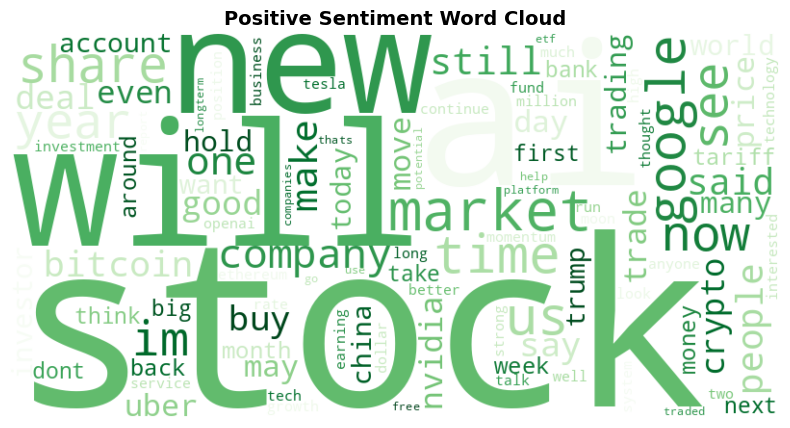

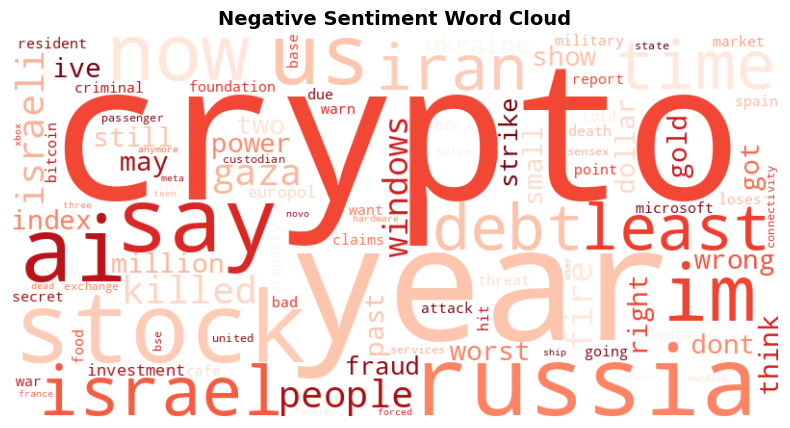

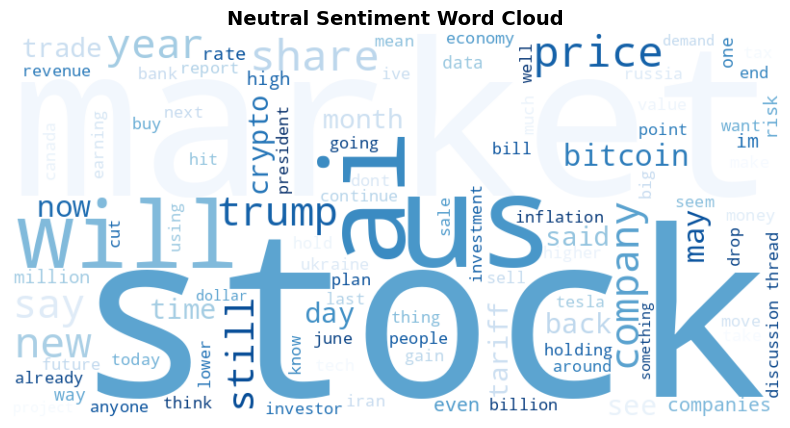


✅ All visualizations completed!


In [34]:
print("\n🎨 Advanced Sentiment Analysis Visualizations")
print("=" * 50)

# WORD CLOUDS

def generate_wordcloud(text, title, color):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap=color,
        max_words=100,
        random_state=42
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment
positive_text = ' '.join(combined_df[combined_df['sentiment_textblob'] == 'positive']['text_clean'])
negative_text = ' '.join(combined_df[combined_df['sentiment_textblob'] == 'negative']['text_clean'])
neutral_text = ' '.join(combined_df[combined_df['sentiment_textblob'] == 'neutral']['text_clean'])

if positive_text:
    generate_wordcloud(positive_text, 'Positive Sentiment Word Cloud', 'Greens')
if negative_text:
    generate_wordcloud(negative_text, 'Negative Sentiment Word Cloud', 'Reds')
if neutral_text:
    generate_wordcloud(neutral_text, 'Neutral Sentiment Word Cloud', 'Blues')

# DISTRIBUTION CHARTS

# Sentiment distribution by source
fig = px.histogram(
    combined_df,
    x='sentiment_textblob',
    color='source',
    barmode='group',
    title='Sentiment Distribution by Source (TextBlob)',
    labels={'sentiment_textblob': 'Sentiment', 'count': 'Count'},
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig.update_layout(showlegend=True, xaxis_title='Sentiment', yaxis_title='Count')
fig.show()

# ADVANCED VISUALIZATIONS

# 1. Stacked Bar: Sentiment by Source and Topic (Top 5 topics)
top_topics = combined_df['topic'].value_counts().head(5).index
filtered_df = combined_df[combined_df['topic'].isin(top_topics)]
fig1 = px.histogram(
    filtered_df,
    x='source',
    color='sentiment_textblob',
    facet_col='topic',
    barmode='stack',
    title='Sentiment Distribution by Source and Top 5 Topics'
)
fig1.update_layout(height=600)
fig1.show()

# 2. Time Series: Daily Sentiment Trends by Source
daily_sentiment = combined_df.groupby([pd.Grouper(key='created_at', freq='D'), 'source'])['sentiment_numeric_textblob'].mean().reset_index()
fig2 = go.Figure()
for source in daily_sentiment['source'].unique():
    source_data = daily_sentiment[daily_sentiment['source'] == source]
    fig2.add_trace(go.Scatter(
        x=source_data['created_at'],
        y=source_data['sentiment_numeric_textblob'],
        mode='lines+markers',
        name=source
    ))
# Add annotation for peak sentiment
peak_idx = daily_sentiment['sentiment_numeric_textblob'].idxmax()
peak_date = daily_sentiment.loc[peak_idx, 'created_at']
peak_value = daily_sentiment.loc[peak_idx, 'sentiment_numeric_textblob']
fig2.add_annotation(x=peak_date, y=peak_value, text="Peak Sentiment", showarrow=True)
fig2.update_layout(title='Daily Sentiment Trends by Source', template='plotly_dark')
fig2.show()

# 3. Bubble Chart: Sentiment vs Engagement by Source
agg_df = combined_df.groupby('source').agg({
    'sentiment_numeric_textblob': 'mean',
    'engagement_score': 'mean',
    'text': 'count'
}).reset_index()
fig3 = px.scatter(
    agg_df,
    x='sentiment_numeric_textblob',
    y='engagement_score',
    size='text',
    color='source',
    title='Average Sentiment vs Engagement Score by Source',
    labels={
        'sentiment_numeric_textblob': 'Average Sentiment Score',
        'engagement_score': 'Average Engagement Score',
        'text': 'Number of Posts'
    }
)
fig3.show()

# 4. Donut Chart: Technology Topic Sentiment Breakdown
if 'technology' in combined_df['topic'].values:
    tech_data = combined_df[combined_df['topic'] == 'technology']
    fig4 = px.pie(
        tech_data,
        names='sentiment_textblob',
        hole=0.4,
        title='Sentiment Distribution for Technology Topic'
    )
    fig4.show()

# 5. Heatmap: Sentiment by Hour and Source
combined_df['hour'] = combined_df['created_at'].dt.hour
heatmap_data = combined_df.pivot_table(
    values='sentiment_numeric_textblob',
    index='source',
    columns='hour',
    aggfunc='mean'
)
fig5 = px.imshow(
    heatmap_data,
    title='Average Sentiment Score by Hour of Day and Source',
    labels=dict(x="Hour of Day", y="Source", color="Avg Sentiment")
)
fig5.show()

print("\n✅ All visualizations completed!")
print("=" * 50)